In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression



In [214]:
#Load data
full_data = pd.read_csv("Life Expectancy Data.csv")
full_data.info()
cols = ["Life expectancy", "Status", "Alcohol", "GDP", "BMI", "Schooling"]
                   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [215]:
#Clean data
full_data.columns = full_data.columns.str.strip()
data = full_data[cols].dropna()
data2 = data.copy() #Create a second dataframe to be used with the statsmodels instead of scikit-learn

#Create dummy variables for categorical data
data = pd.get_dummies(data, columns=['Status'], drop_first=True)
data

,Life expectancy,Alcohol,GDP,BMI,Schooling,Status_Developing
0,65.0,0.01,584.259210,19.1,10.1,True
1,59.9,0.01,612.696514,18.6,10.0,True
2,59.9,0.01,631.744976,18.1,9.9,True
3,59.5,0.01,669.959000,17.6,9.8,True
4,59.2,0.01,63.537231,17.2,9.5,True
...,...,...,...,...,...,...
2933,44.3,4.36,454.366654,27.1,9.2,True
2934,44.5,4.06,453.351155,26.7,9.5,True
2935,44.8,4.43,57.348340,26.3,10.0,True
2936,45.3,1.72,548.587312,25.9,9.8,True


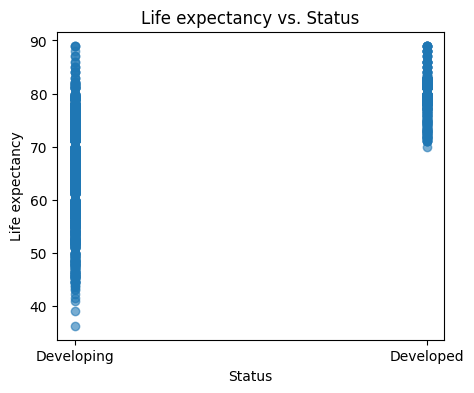

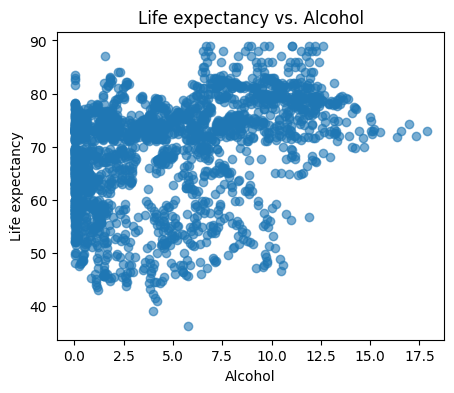

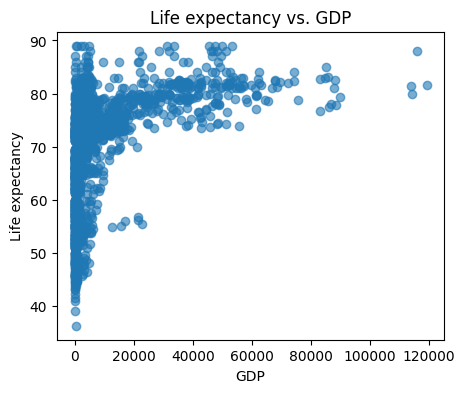

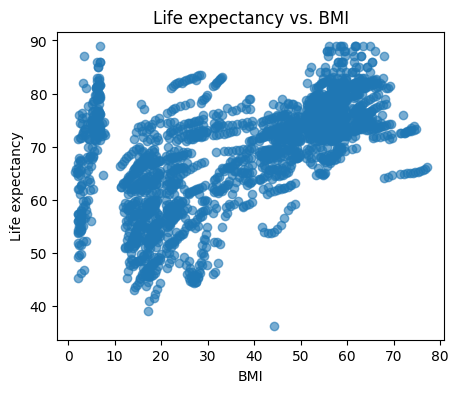

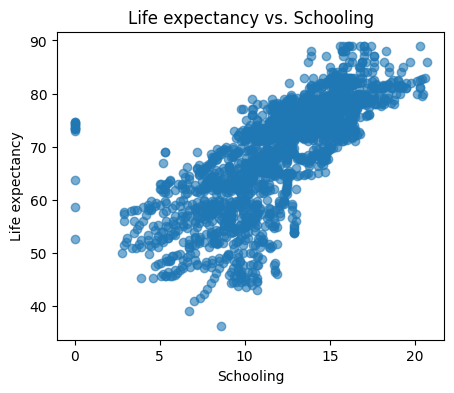

In [216]:
#Ceck predictor vs. response plots
response = cols[0]
predictors = cols[1:]
for col in predictors:
    plt.figure(figsize=(5,4))
    plt.scatter(data2[col], data2[response], alpha=0.6)
    plt.xlabel(col)
    plt.ylabel(response)
    plt.title(f"{response} vs. {col}")
    plt.show()

In [217]:
#I notice that there are many "streaks" in the BMI vs life expectancy plot where a few points look to be correlated.
#This is likely due to the fact that many of these data points are the same country, evaluated at different calendar years.
#lets look to see how many data points we have for each country
print(f"Number of years of data per country: \n{full_data["Country"].value_counts()}\n")
print(f"Number of data points per year: \n{full_data["Year"].value_counts()}")

Number of years of data per country: 
Country
Afghanistan              16
Albania                  16
Algeria                  16
Angola                   16
Antigua and Barbuda      16
                         ..
Monaco                    1
Marshall Islands          1
Saint Kitts and Nevis     1
San Marino                1
Tuvalu                    1
Name: count, Length: 193, dtype: int64

Number of data points per year: 
Year
2013    193
2015    183
2014    183
2012    183
2011    183
2010    183
2009    183
2008    183
2007    183
2006    183
2005    183
2004    183
2003    183
2002    183
2001    183
2000    183
Name: count, dtype: int64


In [218]:
#Because any two data points for the same country are not independent of each other, 
# they will violate the assumption of our linear model that errors are independent.
# Lets look to see which calendar year to use based on the available data.
full_data.groupby("Year")[cols].count()


,Life expectancy,Status,Alcohol,GDP,BMI,Schooling
Year,,,,,,
2000,183,183,182,154,181,173
2001,183,183,182,155,181,173
2002,183,183,182,155,181,173
2003,183,183,182,155,181,173
2004,183,183,182,156,181,173
2005,183,183,181,156,181,173
2006,183,183,182,156,181,173
2007,183,183,182,156,181,173
2008,183,183,182,156,181,173


In [219]:
#Since 2015 only contains 6 data points for alcohol, lets use 2014.
full_data = full_data[full_data["Year"] == 2014]
full_data.columns = full_data.columns.str.strip()

#Load the updated datasets
data = full_data[cols].dropna()
data2 = data.copy()
data = pd.get_dummies(data, columns=['Status'], drop_first=True)

full_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 1 to 2923
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          183 non-null    object 
 1   Year                             183 non-null    int64  
 2   Status                           183 non-null    object 
 3   Life expectancy                  183 non-null    float64
 4   Adult Mortality                  183 non-null    float64
 5   infant deaths                    183 non-null    int64  
 6   Alcohol                          182 non-null    float64
 7   percentage expenditure           183 non-null    float64
 8   Hepatitis B                      173 non-null    float64
 9   Measles                          183 non-null    int64  
 10  BMI                              181 non-null    float64
 11  under-five deaths                183 non-null    int64  
 12  Polio                     

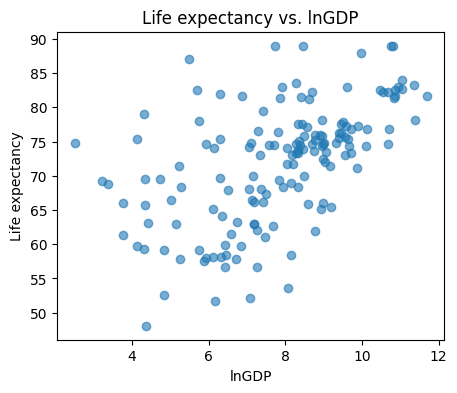

In [220]:
#GDP looks to have a log relationship with life expectancy, so lets log transform the GDP predictor and reassess.
data2["lnGDP"] = np.log(data2["GDP"])
data2
plt.figure(figsize=(5,4))
plt.scatter(data2["lnGDP"], data2["Life expectancy"], alpha=0.6)
plt.xlabel("lnGDP")
plt.ylabel("Life expectancy")
plt.title(f"{"Life expectancy"} vs. {"lnGDP"}")
plt.show()

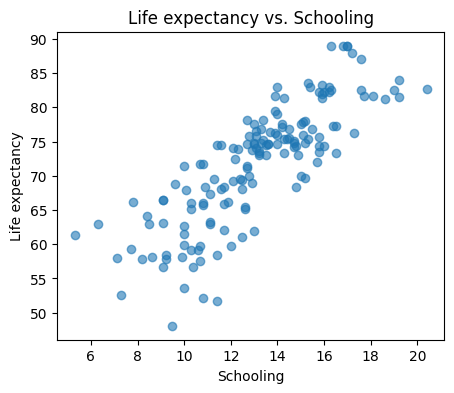

In [221]:
# There looks to be some high-leverage points for the schooling vs life expectancy
# plots for the countries with an average of 0 years of schooling. 
# Lets identify these leverage points and remove them from the dataset.

plt.figure(figsize=(5,4))
plt.scatter(data2["Schooling"], data2["Life expectancy"], alpha=0.6)
plt.xlabel("Schooling")
plt.ylabel("Life expectancy")
plt.title(f"{"Life expectancy"} vs. {"Schooling"}")
plt.annotate("High leverage points", xy=(0.5,75.5), xytext =(2,80),arrowprops=dict(arrowstyle="->", color="black"), fontsize = 8)
plt.show()

In [222]:
#Create a linear model using scikit-learn
y = data["Life expectancy"]
X = data.drop("Life expectancy", axis = 1)
model1 = LinearRegression()
model1.fit(X,y)


#Create a linear model using statsmodels
def clean_name(col):
    return col.strip().replace(" ","_")

data2 = data2.rename(columns=clean_name)
model2 = smf.ols("Life_expectancy ~ Alcohol + lnGDP + BMI + Schooling + C(Status)", data = data2).fit()